# Introduction
* This Notebook implements [ArcFace ](https://arxiv.org/abs/1801.07698) algorithm in pytorch, I also replicated an experiment to visualize distrubution of Embeddings generated using ArcFace loss and Softmax Loss on the MNIST datasets.

# Loss Description
1). Normalize the embeddings and weights vector

2). Calculate the dot products b/w embeddings and weights

3). Calculate the angles with arccos

4). Add a constant factor angular margin m to the angle corresponding to the ground truth label and Turn angles back to cosines

5). Use cross entropy on the new cosine values to calculate loss

**Let's Understand this in details** 
To understand the formula lets first recall cross-entropy loss and softmax definition.


**Softmax cost** function is the average of the loss functions over the training set (or batch), 
$$CE = -\frac{1}{N}\sum_{i=1}^{N}\log(\frac{e^{x_{i}}}{\sum_{j=1}^{n} e^{x_{j}}}).$$
Based on the figure below,

**softmax cost** can be written as
$$CE = -\frac{1}{N}\sum_{i}^{N}\log(\frac{e^{W_{y_{i}}^{T}x_{i} + b_{y_{i}}}}{\sum_{j=1}^{n} e^{W_{j}^{T}x_{i} + b_{j}}}).$$
where $x_{i}$ denotes embedding of the $i$-th sample, belonging to the $y_{i}$-th class (from the image above, $y_{i}=2$). $W_{j}$ denotes the $j$-th column of the weight matrix $W$.

Lets fix $b=\mathbf{0}$, normalize all weight columns $\Vert W_{j}\Vert=1$ and normalize embedding vector $\Vert x\Vert=1$. After normalization, embedding will be distributed on a unit hypersphere. Now we have that 
$$W_{j}^{T}x + b_{j}=\frac{W_{j}^{T}x}{\Vert W_{j}\Vert\Vert x\Vert} = \cos(\langle W_{j}^{T}, x\rangle)=\cos(\theta_{j}).$$

Further, we can easily get $\theta$ angle applying $\arccos$ to both sides and after increase $\theta$ by penalty $m$. From the ArcFace paper https://arxiv.org/pdf/1801.07698.pdf, autors explained it as:  
> We add an additive angular margin penalty $m$ between $x_{i}$ and $W_{y_{i}}$ to simultaneously enhance the intra-class compactness and inter-class discrepancy.

After all, the softmax cost becomes 
$$CE = -\frac{1}{N}\sum_{i}^{N}\log(\frac{e^{s \cos(\theta_{y_{i}}+m)}}{e^{s \cos(\theta_{y_{i}}+m)} + \sum_{j=1, j\neq y_{i}}^{n} e^{s \cos(\theta_{j})}})$$
where $s$ is a scaler that defines the radius of hypersphere where embeddings are distributed. 


# Load Library

In [73]:
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import math


import cv2
import pandas as pd

from torch import nn 
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F 
from torch.nn import ReLU, Conv2d, Linear, Flatten
from torch.optim import lr_scheduler
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn import metrics
from datetime import date
from sklearn.metrics import f1_score, accuracy_score
from collections  import Counter

import random



print(tf.__version__)
%config Completer.use_jedi = False

2.6.4


# Load DataSet

In [74]:
mnist = tf.keras.datasets.mnist
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [75]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(f"Training Data Shape {x_train.shape}")

print(f"Testing Data Shape {x_test.shape}")

Training Data Shape (60000, 28, 28)
Testing Data Shape (10000, 28, 28)


# Display Image

In [76]:
def display_image(data, COLS=4, ROWS=4):
    # iterate over rows     
    for k in range(ROWS):
        # for each row we will set the size of figure
        plt.figure(figsize=(20,5))
        # iterate over all the columns
        for j in range(COLS):
            row = COLS*k + j    
            rand_index=np.random.randint(0,len(data))
            img_sample= data[rand_index]
            plt.subplot(1,COLS,j+1)
            
            plt.axis('off')
            # display image
            
            plt.imshow(img_sample)
        plt.show()
        

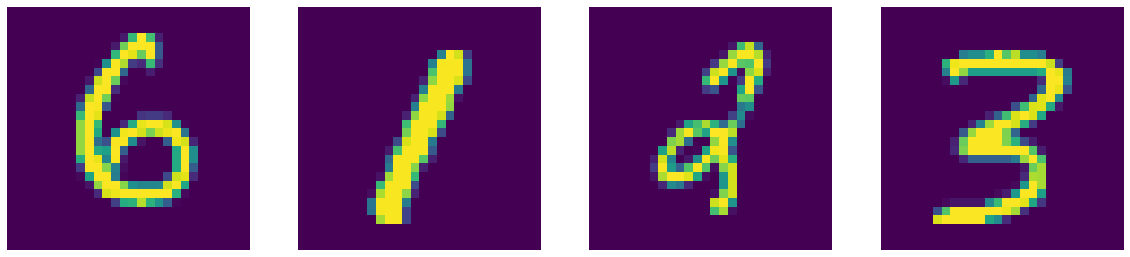

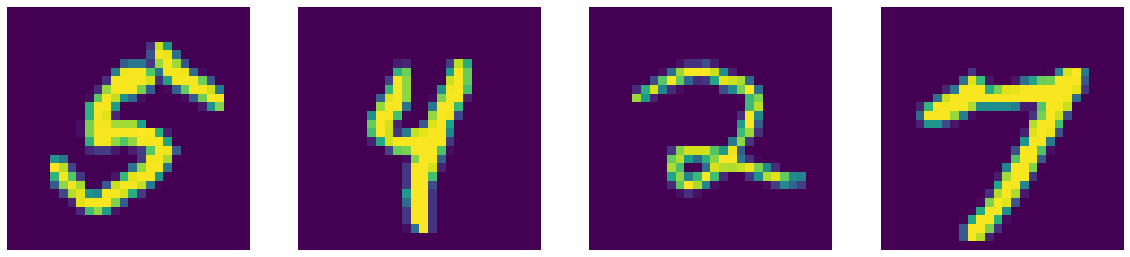

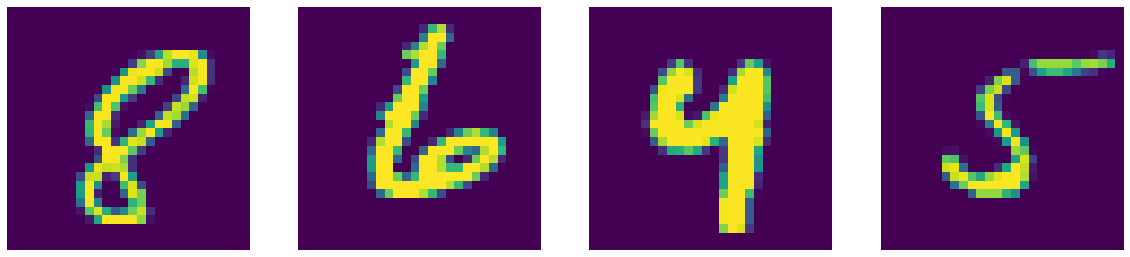

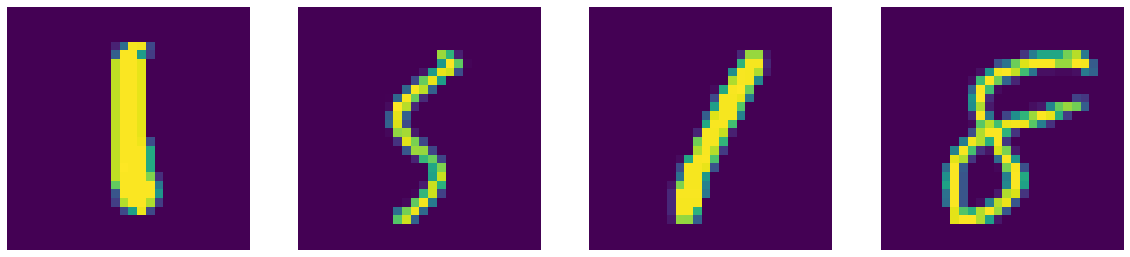

In [77]:
display_image(x_train)


# Setup Dataset


In [78]:
# channel first ordering
x_train = x_train.reshape(-1, 1,28, 28)
x_test = x_test.reshape(-1, 1,28, 28)


# convert to float 
x_train = x_train.astype("float32")/255.0
x_test = x_test.astype("float32")/255.0





x_train = torch.Tensor(x_train) # transform to torch tensor
y_train = torch.tensor(y_train).long()

x_test = torch.Tensor(x_test) # transform to torch tensor
y_test = torch.tensor(y_test).long()


train_dataset = TensorDataset(x_train,y_train) # create your datset
train_dataloader = DataLoader(train_dataset, batch_size=64) # create your dataloader


valid_dataset = TensorDataset(x_test,y_test) # create your datset
valid_dataloader = DataLoader(valid_dataset,batch_size=64) # create your dataloader

# Model

In [79]:
class ArcFaceLoss(nn.Module):
    def __init__(self,margin = 0.4, scale=30, out_classes=10, emb_size =3,  easy_margin=False, ls_eps=0.0):
        super(ArcFaceLoss, self).__init__()
        self.W = nn.Parameter(torch.FloatTensor(out_classes, emb_size))
        nn.init.xavier_uniform_(self.W)
        self.s=scale
        self.m = margin
        self.out_features = out_classes
        self.emb_size=emb_size
        self.easy_margin=easy_margin
        self.ls_eps=ls_eps
        self.cos_m = math.cos(margin)
        self.sin_m = math.sin(margin)
        self.th = math.cos(math.pi - margin)
        self.mm = math.sin(math.pi - margin) * margin
        
        
    def forward(self, x,y):
        # normalize features and normalize weight vectors
        feature_norm =F.normalize(x)
        weight_norm = F.normalize(self.W)
        # cosine = X.W = ||X|| .||W|| . cos(theta) 
        # if X and W are normalize then dot product X, W = will be cos theta
        
        # Get cosine similarity by multiplication 
        # we have normalized features and weight vectors and we don't have bias in
        # in weight vector so weight * features = cosine(features, weights)
        cosine = F.linear(feature_norm,weight_norm)
        cosine = cosine.clip(-1+1e-7, 1-1e-7) 
        
        arcosine = cosine.arccos()
        arcosine += F.one_hot(y, num_classes = self.out_features) * self.m
        cosine2 = arcosine.cos()
        return cosine2
        
        

        
        
        
        

In [80]:
class MnistClassfier(nn.Module):
    def __init__(self, lossType='softmax', emb_size=3, out_classes=10):
        super(MnistClassfier, self).__init__()
        self.lossType = lossType
        self.emb_size=emb_size
        self.conv1 = Conv2d(1,64, kernel_size=3, padding='same')
        self.activation = ReLU()
        self.conv2 = Conv2d(64,128,kernel_size=3,padding='same')
        self.flat = Flatten()
        self.out_classes=out_classes
        self.dense1 = nn.LazyLinear(emb_size)
        if lossType=='softmax':
            self.final = nn.Linear(emb_size, out_classes)
        else:
            self.final = ArcFaceLoss()
        
        
    def get_embs(self, x):
        x = self.conv1(x)
        x = self.activation(x)
        x= self.conv2(x)
        x = self.activation(x)
        x= self.flat(x)
        x=self.dense1(x)
        return x
        
    def forward(self, x,y):
        
        x = self.get_embs(x)
        if self.lossType=='softmax':
            x = self.final(x)   
        else:
            x = self.final(x,y)
            
        return x
        

In [81]:
def training_single_epoch(epoch_num, model,train_dataloader, loss_criteria= None, optimizer=None):
    avgloss =0.0
    # put model on trainng
    model.train()
    print("Loss:",model.lossType)
    tq = tqdm(enumerate(train_dataloader), total=len(train_dataloader)) 
    y_true=[]
    y_pred=[]
    
    
    for idx, data in tq:
        x, y = data
        x = x.to(device)
        y = y.to(device)
        # zero out gradient
        optimizer.zero_grad()
        # forward pass
        out= model(x, y)
        loss = loss_criteria(out,y)
        # backward pass
        loss.backward()
        # step
        optimizer.step()
        
        predictions = torch.argmax(out, 1)
        y_true.extend(y.detach().cpu().numpy())
        y_pred.extend(predictions.detach().cpu().numpy())
        # avg loss
        avgloss += loss.item() 

        tq.set_postfix({'loss' : '%.6f' %float(avgloss/(idx+1))})
        
    # f1score
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Training Epoch {epoch_num} => F1 Score {f1}")
    
    return  avgloss / len(train_dataloader),f1
        

In [82]:
def Validating_single_epoch(epoch_num, model,valid_dataloader, loss_criteria= None):
    avgloss =0.0
    # put model on Evalution
    model.eval()
    
    tq = tqdm(enumerate(valid_dataloader), total=len(valid_dataloader)) 
    y_true=[]
    y_pred=[]
    with torch.no_grad():
    
        for idx, data in tq:
            x, y = data
            x = x.to(device)
            y = y.to(device)

            # forward pass
            out = model(x, y)
            loss = loss_criteria(out,y)
            
            predictions = torch.argmax(out, 1)
            y_true.extend(y.detach().cpu().numpy())
            y_pred.extend(predictions.detach().cpu().numpy())
            # avg loss
            avgloss += loss.item() 

            tq.set_postfix({'loss' : '%.6f' %float(avgloss/(idx+1))})

    # f1score
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Validation Epoch {epoch_num} => F1 Score {f1}")
    
    return  avgloss / len(valid_dataloader),f1
        

In [83]:


def run_training(epochs,model, loss, optimizer, history=None):
    for epoch in range(epochs):
        # training single epoch
        train_avgloss, train_f1 = training_single_epoch(epoch, model,train_dataloader, loss_criteria= loss, optimizer=optimizer)
    
        valid_avgloss, valid_f1 = Validating_single_epoch(epoch, model,valid_dataloader, loss_criteria= loss)

        print("Epoch : {} avg f1 {}".format(epoch+1,train_f1))
        
        history['val_loss'].append(valid_avgloss)
        history['train_loss'].append(train_avgloss)
        history['valid_f1'].append(valid_f1)
        history['train_f1'].append(train_f1)
        
    return model, history
    

# Training Softmax Loss

In [84]:
emb_size=3
n_classes=10
epochs=5

model = MnistClassfier(lossType='softmax')
model.to(device)

loss_criteria = nn.CrossEntropyLoss()
loss_criteria.to(device)

# define optimzer
optimizer = torch.optim.Adam(model.parameters(),lr= 0.001)

history={ 'val_loss':[],
         'train_loss':[],
         'valid_f1':[], 
         'train_f1':[]
        }
model, history= run_training(epochs,model, loss_criteria, optimizer, history=history)

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loss: softmax


100%|██████████| 938/938 [00:08<00:00, 114.42it/s, loss=0.480249]


Training Epoch 0 => F1 Score 0.8498969473940472


100%|██████████| 157/157 [00:00<00:00, 218.10it/s, loss=0.273567]


Validation Epoch 0 => F1 Score 0.9225324636290436
Epoch : 1 avg f1 0.8498969473940472
Loss: softmax


100%|██████████| 938/938 [00:07<00:00, 126.71it/s, loss=0.219116]


Training Epoch 1 => F1 Score 0.9374424583177768


100%|██████████| 157/157 [00:00<00:00, 225.93it/s, loss=0.214975]


Validation Epoch 1 => F1 Score 0.9422637269588547
Epoch : 2 avg f1 0.9374424583177768
Loss: softmax


100%|██████████| 938/938 [00:07<00:00, 128.01it/s, loss=0.158669]


Training Epoch 2 => F1 Score 0.9546075228108848


100%|██████████| 157/157 [00:00<00:00, 220.75it/s, loss=0.201230]


Validation Epoch 2 => F1 Score 0.9479545143865771
Epoch : 3 avg f1 0.9546075228108848
Loss: softmax


100%|██████████| 938/938 [00:07<00:00, 133.55it/s, loss=0.122391]


Training Epoch 3 => F1 Score 0.9641702969575003


100%|██████████| 157/157 [00:01<00:00, 138.89it/s, loss=0.184296]


Validation Epoch 3 => F1 Score 0.9519664846494008
Epoch : 4 avg f1 0.9641702969575003
Loss: softmax


100%|██████████| 938/938 [00:07<00:00, 124.07it/s, loss=0.089473]


Training Epoch 4 => F1 Score 0.9741338701511223


100%|██████████| 157/157 [00:00<00:00, 225.51it/s, loss=0.169817]


Validation Epoch 4 => F1 Score 0.9581688493328834
Epoch : 5 avg f1 0.9741338701511223


# Train ArcFace Loss

In [91]:
emb_size=3
n_classes=10
epochs=15

arcfacemodel = MnistClassfier(lossType='ArcFace')
arcfacemodel.to(device)

loss_criteria = nn.CrossEntropyLoss()
loss_criteria.to(device)

# define optimzer
optimizer = torch.optim.Adam(arcfacemodel.parameters(),lr= 0.001)

arcface_history={ 'val_loss':[],
         'train_loss':[],
         'valid_f1':[], 
         'train_f1':[]
        }
arcfacemodel, arcface_history= run_training(epochs,arcfacemodel, loss_criteria, optimizer, history=arcface_history)

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loss: ArcFace


100%|██████████| 938/938 [00:08<00:00, 115.71it/s, loss=1.767338]


Training Epoch 0 => F1 Score 0.5156577510708524


100%|██████████| 157/157 [00:00<00:00, 225.00it/s, loss=1.648986]


Validation Epoch 0 => F1 Score 0.690666178383171
Epoch : 1 avg f1 0.5156577510708524
Loss: ArcFace


100%|██████████| 938/938 [00:07<00:00, 123.37it/s, loss=1.631913]


Training Epoch 1 => F1 Score 0.7589148717657901


100%|██████████| 157/157 [00:00<00:00, 220.36it/s, loss=1.619169]


Validation Epoch 1 => F1 Score 0.8022676012522076
Epoch : 2 avg f1 0.7589148717657901
Loss: ArcFace


100%|██████████| 938/938 [00:07<00:00, 121.37it/s, loss=1.607923]


Training Epoch 2 => F1 Score 0.8550436480723574


100%|██████████| 157/157 [00:00<00:00, 228.66it/s, loss=1.607917]


Validation Epoch 2 => F1 Score 0.8701666424455983
Epoch : 3 avg f1 0.8550436480723574
Loss: ArcFace


100%|██████████| 938/938 [00:07<00:00, 127.54it/s, loss=1.595937]


Training Epoch 3 => F1 Score 0.906996727885085


100%|██████████| 157/157 [00:00<00:00, 225.51it/s, loss=1.601381]


Validation Epoch 3 => F1 Score 0.908933827715374
Epoch : 4 avg f1 0.906996727885085
Loss: ArcFace


100%|██████████| 938/938 [00:07<00:00, 122.40it/s, loss=1.588102]


Training Epoch 4 => F1 Score 0.9299968044063334


100%|██████████| 157/157 [00:00<00:00, 227.76it/s, loss=1.596339]


Validation Epoch 4 => F1 Score 0.9181874636329995
Epoch : 5 avg f1 0.9299968044063334
Loss: ArcFace


100%|██████████| 938/938 [00:07<00:00, 127.63it/s, loss=1.582332]


Training Epoch 5 => F1 Score 0.9419138213202286


100%|██████████| 157/157 [00:00<00:00, 236.51it/s, loss=1.593669]


Validation Epoch 5 => F1 Score 0.9234682919266035
Epoch : 6 avg f1 0.9419138213202286
Loss: ArcFace


100%|██████████| 938/938 [00:07<00:00, 127.21it/s, loss=1.578115]


Training Epoch 6 => F1 Score 0.9504220797486533


100%|██████████| 157/157 [00:00<00:00, 229.28it/s, loss=1.592561]


Validation Epoch 6 => F1 Score 0.9244977044565561
Epoch : 7 avg f1 0.9504220797486533
Loss: ArcFace


100%|██████████| 938/938 [00:07<00:00, 128.77it/s, loss=1.574305]


Training Epoch 7 => F1 Score 0.9572100810388514


100%|██████████| 157/157 [00:00<00:00, 239.30it/s, loss=1.602247]


Validation Epoch 7 => F1 Score 0.91649861113717
Epoch : 8 avg f1 0.9572100810388514
Loss: ArcFace


100%|██████████| 938/938 [00:07<00:00, 126.09it/s, loss=1.571951]


Training Epoch 8 => F1 Score 0.9603898828424775


100%|██████████| 157/157 [00:00<00:00, 246.09it/s, loss=1.589988]


Validation Epoch 8 => F1 Score 0.9297536834112469
Epoch : 9 avg f1 0.9603898828424775
Loss: ArcFace


100%|██████████| 938/938 [00:07<00:00, 128.89it/s, loss=1.568651]


Training Epoch 9 => F1 Score 0.9662254437437389


100%|██████████| 157/157 [00:00<00:00, 248.67it/s, loss=1.590099]


Validation Epoch 9 => F1 Score 0.9284868922740571
Epoch : 10 avg f1 0.9662254437437389
Loss: ArcFace


100%|██████████| 938/938 [00:08<00:00, 114.46it/s, loss=1.566661]


Training Epoch 10 => F1 Score 0.9700107311728969


100%|██████████| 157/157 [00:00<00:00, 215.99it/s, loss=1.587897]


Validation Epoch 10 => F1 Score 0.9321718731039207
Epoch : 11 avg f1 0.9700107311728969
Loss: ArcFace


100%|██████████| 938/938 [00:07<00:00, 122.40it/s, loss=1.565014]


Training Epoch 11 => F1 Score 0.9726497032026596


100%|██████████| 157/157 [00:00<00:00, 176.98it/s, loss=1.588414]


Validation Epoch 11 => F1 Score 0.9308648481096744
Epoch : 12 avg f1 0.9726497032026596
Loss: ArcFace


100%|██████████| 938/938 [00:08<00:00, 113.01it/s, loss=1.563463]


Training Epoch 12 => F1 Score 0.9748496113733317


100%|██████████| 157/157 [00:00<00:00, 212.88it/s, loss=1.590242]


Validation Epoch 12 => F1 Score 0.9281436607798682
Epoch : 13 avg f1 0.9748496113733317
Loss: ArcFace


100%|██████████| 938/938 [00:08<00:00, 114.65it/s, loss=1.561976]


Training Epoch 13 => F1 Score 0.9773273476823663


100%|██████████| 157/157 [00:00<00:00, 209.68it/s, loss=1.586699]


Validation Epoch 13 => F1 Score 0.932829866527389
Epoch : 14 avg f1 0.9773273476823663
Loss: ArcFace


100%|██████████| 938/938 [00:08<00:00, 113.61it/s, loss=1.560698]


Training Epoch 14 => F1 Score 0.9793835646850088


100%|██████████| 157/157 [00:00<00:00, 206.52it/s, loss=1.588687]


Validation Epoch 14 => F1 Score 0.9284720911145901
Epoch : 15 avg f1 0.9793835646850088


# Visualize Embeddings

In [86]:
def getEmbeddings(model, dl):
    model.eval()
    
    tq = enumerate(valid_dataloader)
    embeddings = []
    labels = []
    with torch.no_grad():
        for idx,data in enumerate(dl):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            embeddings.append(model.get_embs(x))
            labels.append(y)
    embeddings = torch.cat(embeddings)
#     embeddings = embeddings / torch.linalg.norm(embeddings,dim=1)[:,None]
    embeddings = embeddings / embeddings.norm(p=2,dim=1)[:,None]
    labels = torch.cat(labels)
    return embeddings,labels

# Get Softmax Embeddings

In [87]:
softmax_emb, softmax_ys = getEmbeddings(model, valid_dataloader)


# Get ArcFace Embeddings

In [92]:
arcface_emb, arcface_ys = getEmbeddings(arcfacemodel, valid_dataloader)


In [89]:
def plot_embs(embeddings, ys, ax):
    # scatter plot of all the labels with different class and plot their embeddings
    # in 3d space
    colors = ['blue','orange','green','purple','red','brown','pink','gray','olive','cyan']
    for k in range(10):
        # if k ==1 , embeddings[ys==k] will get embddings for all the image input
        # with label = 1
        e = embeddings[ys==k].cpu()
        # plot in 3d
        ax.scatter(e[:,0], e[:,1], e[:,2], s=4, alpha=.2, color=colors[k])   

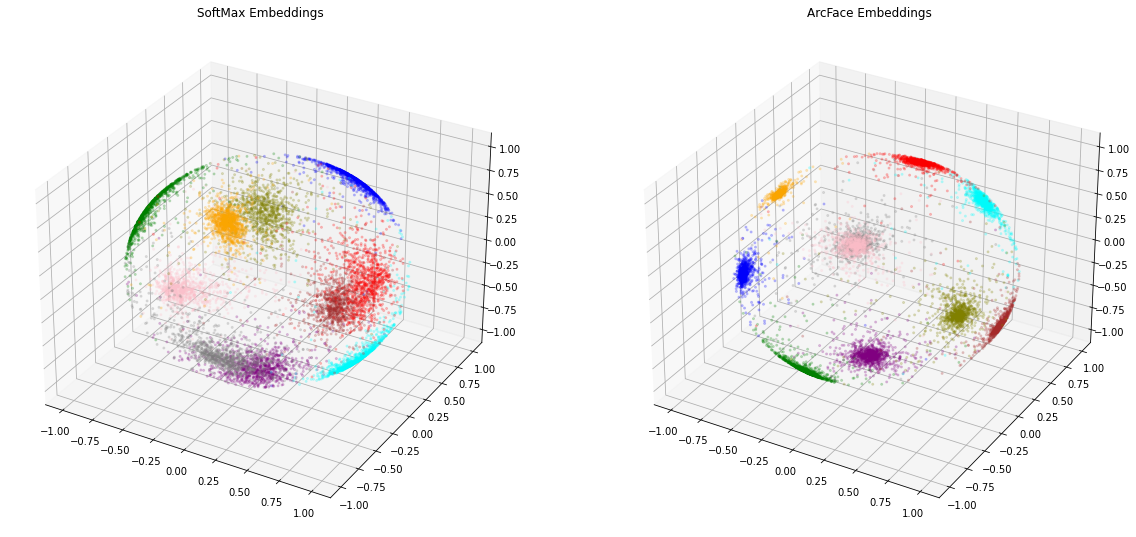

In [94]:
_,(ax1,ax2)=plt.subplots(1,2, figsize=(20,10), subplot_kw={'projection':'3d'})
# plot softmax embeddings
ax1.set_title('SoftMax Embeddings')
ax2.set_title("ArcFace Embeddings")
plot_embs(softmax_emb, softmax_ys, ax1)

# plot arcface embeddings
plot_embs(arcface_emb, arcface_ys, ax2)


plt.show()